In [22]:

import os
import sys
import glob
import logging
import pandas as pd
import mne

# Import your separate pipeline modules
from event_cleaning import clean_events
from epoch_creation import create_and_visualize_epochs
from annotate_raw import annotate_raw_data
from extract_epochs import extract_and_save_epochs
from wave_detection import detect_slow_waves
from wave_classification import classify_and_filter_waves
from wave_filtering import filter_and_save_epochs
from plot_average_waveforms import plot_waveforms
from statistical_analysis import perform_statistical_analysis
from metadata_summary import save_eeg_metadata
from group_analysis import append_to_group_summary
from plot_net_coverage import plot_net_coverage
from interactive_prompt import get_user_choices
from spectrogram_plot import plot_spectrogram_with_annotations
from load_data import load_data
from filter import filter_and_resample
# Import the new topoplot module
from plot_topomaps import plot_topomaps



In [3]:

def setup_logging(output_dir):
    log_file = os.path.join(output_dir, "processing.log")
    logger = logging.getLogger()
    logger.setLevel(logging.INFO)
    
    if logger.hasHandlers():
        logger.handlers.clear()
    
    fh = logging.FileHandler(log_file)
    ch = logging.StreamHandler(sys.stdout)
    
    formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
    fh.setFormatter(formatter)
    ch.setFormatter(formatter)
    
    logger.addHandler(fh)
    logger.addHandler(ch)


In [4]:
# Example usage for testing individual functions
project_dir = "/Users/idohaber/Data"
subject_dir_name = "101"
night_dir_name = "N1"
set_filepath = "/Users/idohaber/Data/101/N1/Strength_101_N1_forSW.set"
output_dir = "/Users/idohaber/Desktop/output"



In [6]:

def get_all_filepaths(project_dir, selected_subjects, selected_nights, set_templates):
    subjects_dirs = [
        d for d in os.listdir(project_dir) 
        if os.path.isdir(os.path.join(project_dir, d))
    ]
    for subject_dir_name in subjects_dirs:
        if selected_subjects != "all" and subject_dir_name not in selected_subjects:
            continue
        subject_dir = os.path.join(project_dir, subject_dir_name)
        all_nights = [
            d for d in os.listdir(subject_dir)
            if os.path.isdir(os.path.join(subject_dir, d))
        ]
        if not all_nights:
            print(f"Warning: No nights found for subject '{subject_dir_name}'. Skipping.")
            continue
        nights = all_nights if selected_nights == "all" else [n for n in all_nights if n in selected_nights]
        for night_dir_name in nights:
            night_dir = os.path.join(subject_dir, night_dir_name)
            for set_pattern in set_templates:
                pattern_to_use = set_pattern.replace('XXX', subject_dir_name) if 'XXX' in set_pattern else set_pattern
                set_filepaths = glob.glob(os.path.join(night_dir, pattern_to_use))
                for set_filepath in set_filepaths:
                    yield (subject_dir_name, night_dir_name, set_filepath)


In [ ]:
raw = load_data(set_filepath)

In [ ]:
# Example: Compare channel names
data_channels = raw.ch_names
montage_channels = mne.channels.make_standard_montage('GSN-HydroCel-256').ch_names

missing_in_data = set(montage_channels) - set(data_channels)
missing_in_montage = set(data_channels) - set(montage_channels)

if missing_in_data:
    print(f"Channels in montage but missing in data: {missing_in_data}")
if missing_in_montage:
    print(f"Channels in data but missing in montage: {missing_in_montage}")


In [ ]:
plot_spectrogram_with_annotations(raw, output_dir)

In [ ]:
raw, sf, filter_details = filter_and_resample(raw)

In [ ]:
plot_net_coverage(raw, output_dir)

In [26]:
cleaned_events_df, durations, omitted_events_df = clean_events(raw)

In [ ]:
pre_stim_epochs, stim_epochs, post_stim_epochs, overlaps = create_and_visualize_epochs(cleaned_events_df, output_dir, sf)

In [ ]:
sw_df = detect_slow_waves(raw)

In [29]:
df_sorted = classify_and_filter_waves(sw_df, pre_stim_epochs, stim_epochs, post_stim_epochs)

In [30]:

sorted_csv_path = os.path.join(output_dir, 'sorted_slow_waves.csv')
df_sorted.to_csv(sorted_csv_path, index=False)


In [ ]:
filter_and_save_epochs(df_sorted, output_dir)

In [32]:
selected_csv_path= '/Users/idohaber/Desktop/output/filtered_epochs_500ms_most_negative.csv'
df_filtered = pd.read_csv(selected_csv_path)

In [ ]:

perform_statistical_analysis(
    df_filtered, output_dir, project_dir, 
    subject_dir_name, night_dir_name, suffix='filtered'
)


In [ ]:
# 17) Annotate raw data
logging.info("Annotating raw data...")
annotate_raw_data(raw.copy(), df_filtered, output_dir, suffix='filtered')


In [ ]:
# 18) Create topographical plots for negative peaks
logging.info("Creating topographical plots for negative peaks...")
# Path to the annotated raw data .set file
annotated_set_file = os.path.join(output_dir, "annotated_raw_filtered.set")
plot_topomaps(annotated_set_file, output_dir, suffix='filtered')


In [26]:
extract_and_save_epochs(raw, df_filtered, sf, output_dir, suffix='filtered')

In [ ]:
plot_waveforms(raw, df_filtered, sf, output_dir, suffix='filtered')

In [ ]:

quant_csv_path = os.path.join(output_dir, 'wave_quantification.csv')
append_to_group_summary(project_dir, subject_dir_name, night_dir_name, quant_csv_path)


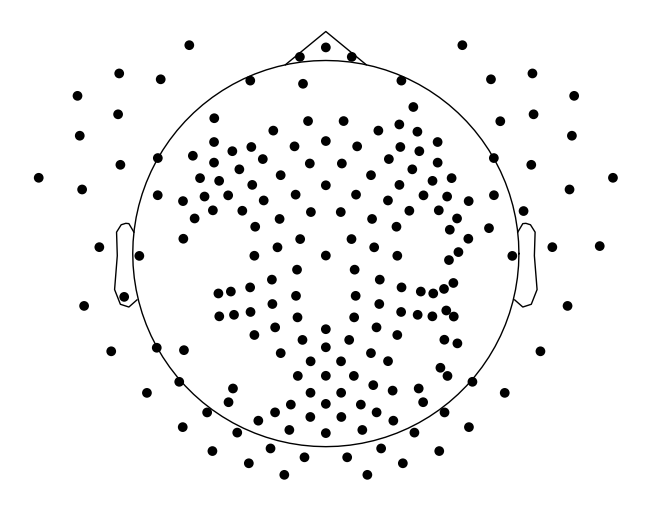

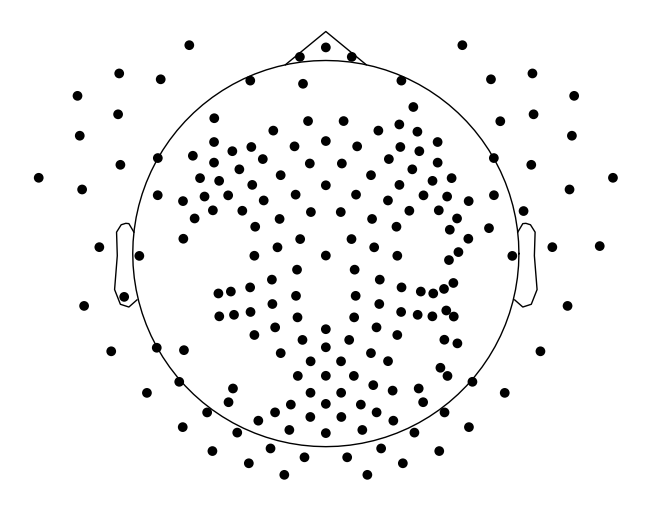

In [ ]:
raw.plot_sensors(show_names=True